Creating Fine-Grained T-Maze Environment...
Grid Shape: (20, 19)
Number of interior bins: 124

Target kernel bandwidth sigma = 2.5 (in grid units)
Precomputing STABLE FD diffusion kernels using matrix exponential...
Stable FD Kernel Matrix shape: (124, 124)

Precomputing GL diffusion kernels...
GL Kernel Matrix shape: (124, 124)

Plotting example kernel (using GL results if available)...
Plotting GL kernel starting near T-junction (interior index 62)...


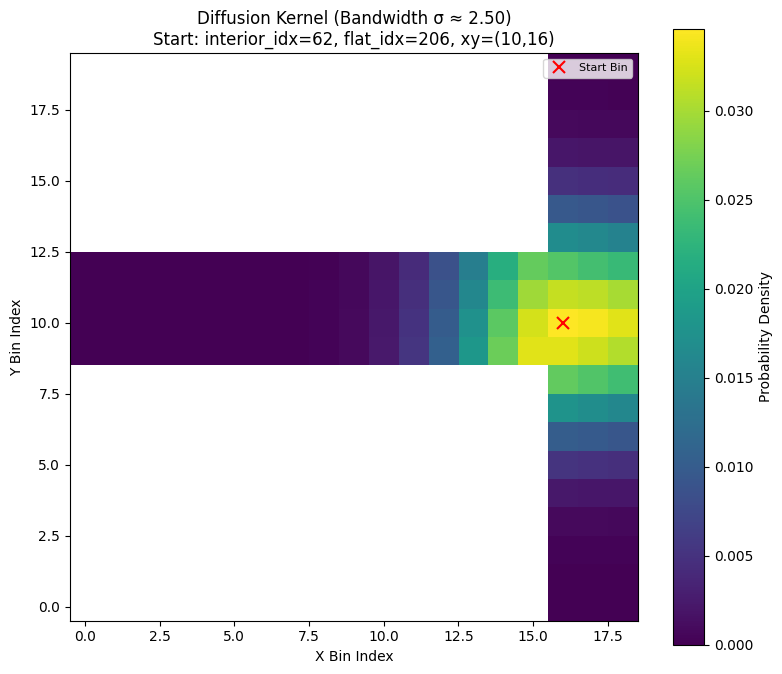

In [8]:
# Create or replace file: non_local_detector/diffusion_kernels.py

from functools import partial
from typing import Tuple

import jax
import jax.numpy as jnp
import jax.scipy.linalg
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np  # Used for env attributes and JAX input conversion


# --- Finite Difference (FD) Approach with JAX & Matrix Exponential (Stable) ---


@partial(jax.jit, static_argnames=["grid_shape"])
def _get_discrete_laplacian_operator_matrix_jax_v2(
    interior_mask_2d: jnp.ndarray, grid_shape: Tuple[int, int]
) -> jnp.ndarray:
    """
    Creates a discrete Laplacian operator matrix using JAX matrix operations
    for interior nodes on a 2D grid, avoiding dynamic boolean indexing
    by separating axis rolls. (L = A - D convention)

    Parameters
    ----------
    interior_mask_2d : jnp.ndarray, shape (n_bins_x, n_bins_y)
    grid_shape : tuple[int, int]

    Returns
    -------
    laplacian_op : jnp.ndarray, shape (n_bins_total, n_bins_total)
    """
    n_bins_total = interior_mask_2d.size
    interior_mask_flat = interior_mask_2d.ravel()
    indices = jnp.arange(n_bins_total)
    adjacency = jnp.zeros((n_bins_total, n_bins_total), dtype=jnp.float32)

    # --- Connections along axis 0 (rows / dim 0 / 'x') ---
    for dr in [1, -1]:  # Down, Up
        shifted_mask_ax0 = jnp.roll(interior_mask_2d, -dr, axis=0)
        valid_connection_mask_ax0 = (interior_mask_2d & shifted_mask_ax0).ravel()
        neighbor_indices_all_ax0 = jnp.roll(
            indices.reshape(grid_shape), -dr, axis=0
        ).ravel()
        values_to_set_ax0 = jnp.where(valid_connection_mask_ax0, 1.0, 0.0)
        # Use add here; connections (i,j) and (j,i) will be added separately ensuring symmetry later
        adjacency = adjacency.at[indices, neighbor_indices_all_ax0].add(
            values_to_set_ax0
        )

    # --- Connections along axis 1 (columns / dim 1 / 'y') ---
    for dc in [1, -1]:  # Right, Left
        shifted_mask_ax1 = jnp.roll(interior_mask_2d, -dc, axis=1)
        valid_connection_mask_ax1 = (interior_mask_2d & shifted_mask_ax1).ravel()
        neighbor_indices_all_ax1 = jnp.roll(
            indices.reshape(grid_shape), -dc, axis=1
        ).ravel()
        values_to_set_ax1 = jnp.where(valid_connection_mask_ax1, 1.0, 0.0)
        adjacency = adjacency.at[indices, neighbor_indices_all_ax1].add(
            values_to_set_ax1
        )

    # Ensure adjacency is symmetric and binary (correcting potential double adds)
    adjacency = jnp.where(adjacency > 0, 1.0, 0.0)

    # Degree matrix D (diagonal matrix of row sums of A)
    degree = jnp.sum(adjacency, axis=1)
    laplacian_op = adjacency - jnp.diag(degree)

    # Ensure operator only acts non-trivially on interior points
    laplacian_op = laplacian_op * interior_mask_flat[:, None]
    laplacian_op = laplacian_op * interior_mask_flat[None, :]

    return laplacian_op


# Pass laplacian_op as regular argument
@partial(jax.jit, static_argnames=["n_bins_total"])
def _get_kernels_for_starts_fd_expm_corrected(
    start_indices: jnp.ndarray,
    n_bins_total: int,
    laplacian_op: jnp.ndarray,
    diffusion_time: float,
    diffusion_coeff: float,
) -> jnp.ndarray:
    """
    Calculates diffusion kernels for multiple start indices using the
    matrix exponential applied to the FD Laplacian operator.
    """
    kernel_matrix_full = jax.scipy.linalg.expm(
        diffusion_coeff * diffusion_time * laplacian_op
    )
    kernels = kernel_matrix_full[:, start_indices]
    return kernels


def precompute_diffusion_kernels_fd(
    interior_mask_2d: np.ndarray,
    bandwidth_sigma: float,
    diffusion_coeff: float = 0.5,
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """
    Precomputes STABLE diffusion kernels for all valid interior bins using
    Finite Differences operator and the Matrix Exponential.

    Parameters
    ----------
    interior_mask_2d : np.ndarray, shape (n_bins_x, n_bins_y)
    bandwidth_sigma : float
    diffusion_coeff : float, optional

    Returns
    -------
    kernel_matrix_interior : jnp.ndarray, shape (n_interior_bins, n_interior_bins)
    interior_bin_indices_flat : jnp.ndarray, shape (n_interior_bins,)
    """
    if diffusion_coeff <= 0:
        raise ValueError("diffusion_coeff must be positive.")

    diffusion_time = bandwidth_sigma**2 / (2 * diffusion_coeff)

    grid_shape = interior_mask_2d.shape
    interior_mask_2d_jax = jnp.asarray(interior_mask_2d)
    interior_mask_flat = interior_mask_2d_jax.ravel()
    n_bins_total = interior_mask_flat.shape[0]
    interior_bin_indices_flat = jnp.where(interior_mask_flat)[0]
    n_interior_bins = interior_bin_indices_flat.shape[0]

    if n_interior_bins == 0:
        return jnp.zeros((0, 0), dtype=jnp.float32), jnp.zeros((0,), dtype=jnp.int32)

    # 1. Precompute Laplacian Operator using the revised function
    laplacian_op = _get_discrete_laplacian_operator_matrix_jax_v2(
        interior_mask_2d_jax, grid_shape
    )

    # 2. Compute all kernels starting from interior bins using matrix exponential
    all_kernels_full_cols = _get_kernels_for_starts_fd_expm_corrected(
        interior_bin_indices_flat,
        n_bins_total,  # Pass as static
        laplacian_op,  # Pass as regular arg
        diffusion_time,
        diffusion_coeff,
    )
    # Result shape: (n_bins_total, n_interior_bins)

    # 3. Filter rows to keep only interior destinations
    kernel_matrix_interior = all_kernels_full_cols[interior_bin_indices_flat, :]
    # Shape: (n_interior_bins, n_interior_bins)

    # 4. Ensure non-negativity and Renormalize columns
    kernel_matrix_interior = jax.nn.relu(kernel_matrix_interior)
    col_sums = kernel_matrix_interior.sum(axis=0, keepdims=True)
    kernel_matrix_interior = jnp.where(
        col_sums > 1e-15, kernel_matrix_interior / col_sums, 0.0
    )

    return kernel_matrix_interior, interior_bin_indices_flat


# --- Graph Laplacian (GL) Approach with JAX (Stable by default) ---


@jax.jit
def _compute_kernel_matrix_from_laplacian(
    laplacian: jnp.ndarray, diffusion_time: float, diffusion_coeff: float
) -> jnp.ndarray:
    """Computes the kernel matrix expm(-D*t*L), where L=D-A."""
    return jax.scipy.linalg.expm(-diffusion_coeff * diffusion_time * laplacian)


def precompute_diffusion_kernels_graph_laplacian(
    track_graphDD: nx.Graph,
    interior_mask_2d: np.ndarray,
    bandwidth_sigma: float,
    diffusion_coeff: float = 0.5,
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """
    Precomputes diffusion kernels for all valid interior bins using the
    Graph Laplacian method and matrix exponential. Stable by definition.

    Parameters
    ----------
    track_graphDD : nx.Graph
    interior_mask_2d : np.ndarray, shape (n_bins_x, n_bins_y)
    bandwidth_sigma : float
    diffusion_coeff : float, optional

    Returns
    -------
    kernel_matrix_interior : jnp.ndarray, shape (n_interior_bins, n_interior_bins)
    interior_bin_indices_flat : jnp.ndarray, shape (n_interior_bins,)
    """
    if diffusion_coeff <= 0:
        ValueError("diffusion_coeff must be positive.")
    if track_graphDD is None:
        ValueError("track_graphDD is required.")
    diffusion_time = bandwidth_sigma**2 / (2 * diffusion_coeff)
    n_bins_total = interior_mask_2d.size
    interior_mask_flat = jnp.asarray(interior_mask_2d.ravel())
    interior_bin_indices_flat = jnp.where(interior_mask_flat)[0]
    n_interior_bins = interior_bin_indices_flat.shape[0]
    if n_interior_bins == 0:
        return jnp.zeros((0, 0)), jnp.zeros((0,))
    node_list = sorted(list(track_graphDD.nodes()))
    if not node_list:
        laplacian_full = jnp.zeros((n_bins_total, n_bins_total), dtype=jnp.float32)
    else:
        try:
            L_sparse = nx.laplacian_matrix(
                track_graphDD, nodelist=range(n_bins_total), weight=None
            )
            laplacian_full = jnp.array(L_sparse.toarray(), dtype=jnp.float32)
        except nx.NetworkXError:
            L_sparse_sub = nx.laplacian_matrix(
                track_graphDD, nodelist=node_list, weight=None
            )
            L_sub = jnp.array(L_sparse_sub.toarray(), dtype=jnp.float32)
            laplacian_full = jnp.zeros((n_bins_total, n_bins_total), dtype=jnp.float32)
            idx_embed = jnp.ix_(jnp.array(node_list), jnp.array(node_list))
            laplacian_full = laplacian_full.at[idx_embed].set(L_sub)
    full_kernel_matrix = _compute_kernel_matrix_from_laplacian(
        laplacian_full, diffusion_time, diffusion_coeff
    )
    idx_filter = jnp.ix_(interior_bin_indices_flat, interior_bin_indices_flat)
    kernel_matrix_interior = full_kernel_matrix[idx_filter]
    kernel_matrix_interior = jax.nn.relu(kernel_matrix_interior)
    col_sums = kernel_matrix_interior.sum(axis=0, keepdims=True)
    kernel_matrix_interior = jnp.where(
        col_sums > 1e-15, kernel_matrix_interior / col_sums, 0.0
    )
    return kernel_matrix_interior, interior_bin_indices_flat


# --- Plotting Function (Unchanged from previous version) ---


def plot_diffusion_kernel_2d(
    kernel_matrix_interior: jnp.ndarray,
    interior_bin_indices_flat: jnp.ndarray,
    interior_mask_2d: np.ndarray,
    grid_shape: tuple[int, int],
    bandwidth_sigma: float,  # Added for title
    start_kernel_index: int = 0,
    ax: plt.Axes = None,
    **imshow_kwargs,
):
    # ... (implementation from previous response) ...
    n_bins_total = np.prod(grid_shape)
    n_interior_bins = interior_bin_indices_flat.shape[0]
    if not (0 <= start_kernel_index < n_interior_bins):
        raise IndexError("start_kernel_index out of bounds")
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    kernel_vector_interior = kernel_matrix_interior[:, start_kernel_index]
    full_grid_kernel = (
        jnp.zeros(n_bins_total)
        .at[interior_bin_indices_flat]
        .set(kernel_vector_interior)
    )
    kernel_2d = full_grid_kernel.reshape(grid_shape)
    plot_data = np.array(kernel_2d, copy=True, dtype=np.float64)
    plot_data[~interior_mask_2d] = np.nan
    aspect_ratio = grid_shape[1] / grid_shape[0]  # ny / nx
    default_kwargs = dict(
        cmap="viridis", interpolation="nearest", origin="lower", aspect=aspect_ratio
    )
    default_kwargs.update(imshow_kwargs)
    im = ax.imshow(plot_data, **default_kwargs)
    plt.colorbar(im, ax=ax, label="Probability Density", shrink=0.8)
    start_bin_flat = interior_bin_indices_flat[start_kernel_index]
    start_bin_r, start_bin_c = np.unravel_index(int(start_bin_flat), grid_shape)
    ax.plot(
        start_bin_c,
        start_bin_r,
        "rx",
        markersize=8,
        markeredgewidth=1.5,
        label="Start Bin",
    )
    ax.set_title(
        f"Diffusion Kernel (Bandwidth σ ≈ {bandwidth_sigma:.2f})\nStart: interior_idx={start_kernel_index}, flat_idx={start_bin_flat}, xy=({start_bin_r},{start_bin_c})"
    )
    ax.set_xlabel("X Bin Index")
    ax.set_ylabel("Y Bin Index")
    ax.legend(fontsize=8)
    ax.grid(False)


# --- Example Usage with Fine-Grained T-Maze ---


# Assume 'env' is your fitted Environment object
class MockTmazeEnvironmentFine:  # As defined previously
    def __init__(self, stem_length=16, stem_width=3, top_length=20, top_width=3):
        nx_bins = top_length
        ny_bins = stem_length + top_width
        self.centers_shape_ = (nx_bins, ny_bins)
        self.is_track_interior_ = np.zeros(self.centers_shape_, dtype=bool)
        stem_start_col = (nx_bins // 2) - (stem_width // 2)
        stem_end_col = stem_start_col + stem_width
        if stem_width % 2 != 0 and nx_bins % 2 == 0:
            stem_end_col += 1
        elif stem_width % 2 == 0 and nx_bins % 2 != 0:
            stem_end_col += 1
        self.is_track_interior_[stem_start_col:stem_end_col, 0:stem_length] = True
        top_start_row = stem_length
        top_end_row = top_start_row + top_width
        self.is_track_interior_[:, top_start_row:top_end_row] = True
        self.n_bins_total_ = np.prod(self.centers_shape_)
        self.track_graphDD = nx.Graph()
        node_inds = np.arange(self.n_bins_total_).reshape(self.centers_shape_)
        for r in range(self.centers_shape_[0]):
            for c in range(self.centers_shape_[1]):
                node_id = int(node_inds[r, c])
                if self.is_track_interior_[r, c]:
                    self.track_graphDD.add_node(node_id)
                    for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                        nr, nc = r + dr, c + dc
                        if (
                            0 <= nr < self.centers_shape_[0]
                            and 0 <= nc < self.centers_shape_[1]
                            and self.is_track_interior_[nr, nc]
                        ):
                            neighbor_id = int(node_inds[nr, nc])
                            self.track_graphDD.add_edge(
                                node_id, neighbor_id, distance=1.0
                            )


# Create the environment
print("Creating Fine-Grained T-Maze Environment...")
fine_t_maze_env = MockTmazeEnvironmentFine()
print(f"Grid Shape: {fine_t_maze_env.centers_shape_}")
print(f"Number of interior bins: {np.sum(fine_t_maze_env.is_track_interior_)}")

# Define bandwidth
sigma_bandwidth = 2.5
print(f"\nTarget kernel bandwidth sigma = {sigma_bandwidth} (in grid units)")


# --- Finite Difference Precomputation (Using corrected Laplacian builder) ---
print("Precomputing STABLE FD diffusion kernels using matrix exponential...")
fd_kernel_matrix, fd_interior_indices = None, None  # Initialize
try:
    # Make sure to use the corrected function name here if you renamed it in your file
    fd_kernel_matrix, fd_interior_indices = precompute_diffusion_kernels_fd(
        fine_t_maze_env.is_track_interior_, sigma_bandwidth
    )
    print(f"Stable FD Kernel Matrix shape: {fd_kernel_matrix.shape}")
    # print(f"Stable FD Interior Indices shape: {fd_interior_indices.shape}")
    # print(f"Stable FD Example column sums: {fd_kernel_matrix.sum(axis=0)[:min(5, fd_kernel_matrix.shape[1])]}")
except Exception as e:
    print(f"Stable FD calculation failed: {e}")


# --- Graph Laplacian Precomputation ---
print("\nPrecomputing GL diffusion kernels...")
gl_kernel_matrix, gl_interior_indices = None, None  # Initialize
try:
    gl_kernel_matrix, gl_interior_indices = (
        precompute_diffusion_kernels_graph_laplacian(
            fine_t_maze_env.track_graphDD,
            fine_t_maze_env.is_track_interior_,
            sigma_bandwidth,
        )
    )
    print(f"GL Kernel Matrix shape: {gl_kernel_matrix.shape}")
    # print(f"GL Interior Indices shape: {gl_interior_indices.shape}")
    # print(f"GL Example column sums: {gl_kernel_matrix.sum(axis=0)[:min(5, gl_kernel_matrix.shape[1])]}")

except Exception as e:
    print(f"GL calculation failed: {e}")  # Note: x2APIC error is external to this code.


# --- Plotting (using GL results if available) ---
print("\nPlotting example kernel (using GL results if available)...")
plot_matrix, plot_indices, method_name = (
    (gl_kernel_matrix, gl_interior_indices, "GL")
    if gl_kernel_matrix is not None
    else (fd_kernel_matrix, fd_interior_indices, "FD")
)

if plot_matrix is not None:
    n_interior_fine = plot_matrix.shape[0]
    if n_interior_fine > 0:
        # Choose start bin near junction
        junction_r = fine_t_maze_env.centers_shape_[0] // 2
        junction_c = 16  # Stem length
        start_flat_index_approx = np.ravel_multi_index(
            (junction_r, junction_c), fine_t_maze_env.centers_shape_
        )
        actual_indices_r, actual_indices_c = np.unravel_index(
            plot_indices, fine_t_maze_env.centers_shape_
        )
        distances = np.sqrt(
            (actual_indices_r - junction_r) ** 2 + (actual_indices_c - junction_c) ** 2
        )
        start_kernel_idx_fine = np.argmin(distances)

        print(
            f"Plotting {method_name} kernel starting near T-junction (interior index {start_kernel_idx_fine})..."
        )
        plot_diffusion_kernel_2d(
            kernel_matrix_interior=plot_matrix,
            interior_bin_indices_flat=plot_indices,
            interior_mask_2d=fine_t_maze_env.is_track_interior_,
            grid_shape=fine_t_maze_env.centers_shape_,
            start_kernel_index=start_kernel_idx_fine,
            bandwidth_sigma=sigma_bandwidth,
            vmin=0,
        )
        plt.tight_layout()
        plt.show()
    else:
        print("No interior bins found to plot kernel for.")
else:
    print("Kernel matrix (neither GL nor FD) not available for plotting.")

Creating Fine-Grained T-Maze Environment...
Fine Grid Shape: (20, 19)
Total bins: 380
Number of interior bins: 124

Target kernel bandwidth sigma = 3.0
Precomputing Boundary-Aware GL diffusion kernels...
Boundary GL Kernel Matrix computed. Shape: (124, 124)

Computing Gaussian kernel starting at bin 191 (Coords: (10, 1))...
Gaussian kernel computed. Shape: (20, 19)

Plotting comparison...


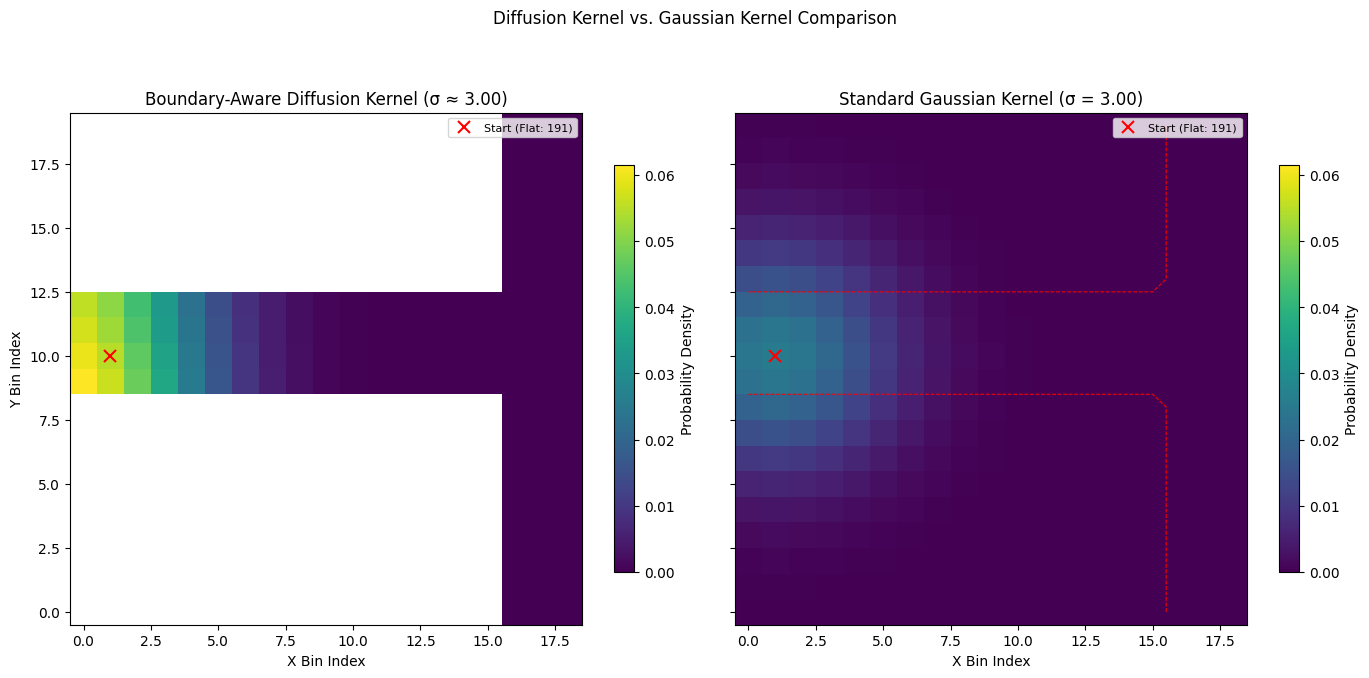

In [13]:
# Create or replace file: non_local_detector/diffusion_kernels.py

from functools import partial
from typing import Tuple

import jax
import jax.numpy as jnp
import jax.scipy.linalg
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np  # Used for env attributes and JAX input conversion
from scipy.stats import multivariate_normal as scipy_multivariate_normal


# --- Mock Environment Definition ---
class MockTmazeEnvironmentFine:
    """Creates a mock environment representing a T-shaped maze grid."""

    def __init__(self, stem_length=16, stem_width=3, top_length=20, top_width=3):
        nx_bins = top_length
        ny_bins = stem_length + top_width
        self.centers_shape_ = (nx_bins, ny_bins)
        self.is_track_interior_ = np.zeros(self.centers_shape_, dtype=bool)
        print(f"Fine Grid Shape: {self.centers_shape_}")

        # Define T-Shape Interior
        stem_start_col = (nx_bins // 2) - (stem_width // 2)
        stem_end_col = stem_start_col + stem_width
        if stem_width % 2 != 0 and nx_bins % 2 == 0:
            stem_end_col += 1
        elif stem_width % 2 == 0 and nx_bins % 2 != 0:
            stem_end_col += 1
        self.is_track_interior_[stem_start_col:stem_end_col, 0:stem_length] = True
        top_start_row = stem_length
        top_end_row = top_start_row + top_width
        self.is_track_interior_[:, top_start_row:top_end_row] = True

        self.n_bins_total_ = np.prod(self.centers_shape_)
        print(f"Total bins: {self.n_bins_total_}")
        print(f"Number of interior bins: {np.sum(self.is_track_interior_)}")

        # --- Calculate Bin Centers (assuming unit spacing) ---
        # Create coordinate vectors for each dimension's centers
        x_centers = np.arange(nx_bins) + 0.5
        y_centers = np.arange(ny_bins) + 0.5
        # Create meshgrid
        X_centers, Y_centers = np.meshgrid(x_centers, y_centers, indexing="ij")
        # Stack and reshape to get (n_bins_total, 2)
        self.place_bin_centers_ = np.stack(
            [X_centers.ravel(), Y_centers.ravel()], axis=1
        )
        # -------------------------------------------------------

        # Build graph connecting adjacent interior bins
        self.track_graphDD = nx.Graph()
        node_inds = np.arange(self.n_bins_total_).reshape(self.centers_shape_)
        for r in range(self.centers_shape_[0]):
            for c in range(self.centers_shape_[1]):
                node_id = int(node_inds[r, c])
                if self.is_track_interior_[r, c]:
                    self.track_graphDD.add_node(node_id)
                    for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                        nr, nc = r + dr, c + dc
                        if (
                            0 <= nr < self.centers_shape_[0]
                            and 0 <= nc < self.centers_shape_[1]
                            and self.is_track_interior_[nr, nc]
                        ):
                            neighbor_id = int(node_inds[nr, nc])
                            self.track_graphDD.add_edge(
                                node_id, neighbor_id, distance=1.0
                            )


# --- Diffusion Kernel Functions (Graph Laplacian method needed) ---


@jax.jit
def _compute_kernel_matrix_from_laplacian(
    laplacian: jnp.ndarray, diffusion_time: float, diffusion_coeff: float
) -> jnp.ndarray:
    """Computes the kernel matrix expm(-D*t*L), where L=D-A."""
    return jax.scipy.linalg.expm(-diffusion_coeff * diffusion_time * laplacian)


def precompute_diffusion_kernels_graph_laplacian(
    track_graphDD: nx.Graph,
    interior_mask_2d: np.ndarray,
    bandwidth_sigma: float,
    diffusion_coeff: float = 0.5,
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    # ... (implementation from previous response, unchanged) ...
    if diffusion_coeff <= 0:
        ValueError("diffusion_coeff must be positive.")
    if track_graphDD is None:
        ValueError("track_graphDD is required.")
    diffusion_time = bandwidth_sigma**2 / (2 * diffusion_coeff)
    n_bins_total = interior_mask_2d.size
    interior_mask_flat = jnp.asarray(interior_mask_2d.ravel())
    interior_bin_indices_flat = jnp.where(interior_mask_flat)[0]
    n_interior_bins = interior_bin_indices_flat.shape[0]
    if n_interior_bins == 0:
        return jnp.zeros((0, 0)), jnp.zeros((0,))
    node_list = sorted(list(track_graphDD.nodes()))
    if not node_list:
        laplacian_full = jnp.zeros((n_bins_total, n_bins_total), dtype=jnp.float32)
    else:
        try:
            L_sparse = nx.laplacian_matrix(
                track_graphDD, nodelist=range(n_bins_total), weight=None
            )
            laplacian_full = jnp.array(L_sparse.toarray(), dtype=jnp.float32)
        except nx.NetworkXError:
            L_sparse_sub = nx.laplacian_matrix(
                track_graphDD, nodelist=node_list, weight=None
            )
            L_sub = jnp.array(L_sparse_sub.toarray(), dtype=jnp.float32)
            laplacian_full = jnp.zeros((n_bins_total, n_bins_total), dtype=jnp.float32)
            idx_embed = jnp.ix_(jnp.array(node_list), jnp.array(node_list))
            laplacian_full = laplacian_full.at[idx_embed].set(L_sub)
    full_kernel_matrix = _compute_kernel_matrix_from_laplacian(
        laplacian_full, diffusion_time, diffusion_coeff
    )
    idx_filter = jnp.ix_(interior_bin_indices_flat, interior_bin_indices_flat)
    kernel_matrix_interior = full_kernel_matrix[idx_filter]
    kernel_matrix_interior = jax.nn.relu(kernel_matrix_interior)
    col_sums = kernel_matrix_interior.sum(axis=0, keepdims=True)
    kernel_matrix_interior = jnp.where(
        col_sums > 1e-15, kernel_matrix_interior / col_sums, 0.0
    )
    return kernel_matrix_interior, interior_bin_indices_flat


# --- Function to calculate standard Gaussian PDF Kernel ---


def calculate_gaussian_kernel_2d(
    all_bin_centers: np.ndarray,  # Shape (n_total_bins, 2)
    grid_shape: Tuple[int, int],
    start_bin_flat_index: int,
    bandwidth_sigma: float,
) -> np.ndarray:
    """
    Calculates a standard 2D Gaussian PDF kernel evaluated on the grid centers.

    Parameters
    ----------
    all_bin_centers : np.ndarray, shape (n_total_bins, 2)
        Coordinates of the center of every bin in the grid.
    grid_shape : tuple[int, int]
        Shape of the 2D grid (nx, ny).
    start_bin_flat_index : int
        Flat index (0..n_total_bins-1) of the bin where the Gaussian is centered.
    bandwidth_sigma : float
        Standard deviation (bandwidth) of the Gaussian kernel along each axis.

    Returns
    -------
    gaussian_kernel_2d : np.ndarray, shape (nx, ny)
        The Gaussian PDF evaluated at each bin center, reshaped to the grid.
        Normalized to sum to 1 over the entire grid.
    """
    n_bins_total = np.prod(grid_shape)
    if not (0 <= start_bin_flat_index < n_bins_total):
        raise IndexError(
            f"start_bin_flat_index ({start_bin_flat_index}) out of bounds."
        )

    # Center of the Gaussian
    mean = all_bin_centers[start_bin_flat_index]

    # Covariance matrix (isotropic)
    covariance = np.array([[bandwidth_sigma**2, 0], [0, bandwidth_sigma**2]])

    # Evaluate PDF at all bin centers
    try:
        pdf_values = scipy_multivariate_normal.pdf(
            all_bin_centers, mean=mean, cov=covariance
        )
    except np.linalg.LinAlgError:
        print(
            "Warning: Covariance matrix singular for Gaussian PDF. Using tiny variance."
        )
        # Handle case where sigma is zero or very close to it
        tiny_variance = 1e-10
        covariance = np.array([[tiny_variance, 0], [0, tiny_variance]])
        pdf_values = scipy_multivariate_normal.pdf(
            all_bin_centers, mean=mean, cov=covariance
        )

    # Normalize the PDF values over the grid so they sum to 1
    pdf_sum = pdf_values.sum()
    if pdf_sum > 1e-15:
        normalized_pdf_values = pdf_values / pdf_sum
    else:
        normalized_pdf_values = (
            pdf_values  # Avoid division by zero if PDF is zero everywhere
        )

    # Reshape to 2D grid
    gaussian_kernel_2d = normalized_pdf_values.reshape(grid_shape)

    return gaussian_kernel_2d


# --- Plotting Function for Comparison ---


def plot_kernel_comparison(
    kernel_boundary_aware: jnp.ndarray,  # Shape (n_interior, n_interior)
    interior_indices: jnp.ndarray,  # Shape (n_interior,)
    kernel_gaussian: np.ndarray,  # Shape (nx, ny) - Already 2D
    interior_mask_2d: np.ndarray,
    grid_shape: tuple[int, int],
    bandwidth_sigma: float,
    start_bin_flat: int,  # Flat index (0..n_total-1) of the start bin
    **imshow_kwargs,
):
    """Plots boundary-aware diffusion vs. standard Gaussian kernels."""

    n_bins_total = np.prod(grid_shape)
    n_interior_bins = interior_indices.shape[0]

    # --- Prepare boundary-aware kernel for plotting ---
    start_kernel_index_interior_list = np.where(interior_indices == start_bin_flat)[0]
    if len(start_kernel_index_interior_list) == 0:
        print(
            f"Warning: Start bin {start_bin_flat} is not interior. Boundary kernel plot omitted."
        )
        plot_data_boundary = np.full(grid_shape, np.nan)  # Plot NaNs
        start_kernel_index_interior = -1
    else:
        start_kernel_index_interior = start_kernel_index_interior_list[0]
        kernel_vector_boundary = kernel_boundary_aware[:, start_kernel_index_interior]
        full_grid_boundary = (
            jnp.zeros(n_bins_total).at[interior_indices].set(kernel_vector_boundary)
        )
        kernel_2d_boundary = full_grid_boundary.reshape(grid_shape)
        plot_data_boundary = np.array(kernel_2d_boundary, copy=True, dtype=np.float64)
        plot_data_boundary[~interior_mask_2d] = np.nan  # Mask non-interior

    # --- Prepare Gaussian kernel for plotting ---
    # Already 2D, use directly
    plot_data_gaussian = np.array(kernel_gaussian, copy=True, dtype=np.float64)

    # --- Plotting ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
    start_bin_r, start_bin_c = np.unravel_index(start_bin_flat, grid_shape)
    aspect_ratio = grid_shape[1] / grid_shape[0]  # ny / nx

    # Determine common color limits based on max value in *either* plot for fair comparison
    valid_max_boundary = (
        0 if start_kernel_index_interior == -1 else np.nanmax(plot_data_boundary)
    )
    valid_max_gaussian = np.nanmax(plot_data_gaussian)
    vmax = max(valid_max_boundary, valid_max_gaussian)
    vmin = 0  # Or adjust if needed, but 0 makes sense for probability

    default_kwargs = dict(
        cmap="viridis",
        interpolation="nearest",
        origin="lower",
        aspect=aspect_ratio,
        vmin=vmin,
        vmax=vmax,
    )
    user_kwargs = imshow_kwargs.copy()
    user_kwargs.setdefault("vmin", vmin)  # Ensure vmin/vmax are set
    user_kwargs.setdefault("vmax", vmax)
    final_kwargs = {**default_kwargs, **user_kwargs}  # User overrides defaults

    # Plot Boundary-Aware Kernel
    ax = axes[0]
    if start_kernel_index_interior != -1:
        im = ax.imshow(plot_data_boundary, **final_kwargs)
        plt.colorbar(im, ax=ax, label="Probability Density", shrink=0.7)
        ax.plot(
            start_bin_c,
            start_bin_r,
            "rx",
            markersize=8,
            markeredgewidth=1.5,
            label=f"Start (Flat: {start_bin_flat})",
        )
        ax.set_title(f"Boundary-Aware Diffusion Kernel (σ ≈ {bandwidth_sigma:.2f})")
    else:
        # Still show grid if start was not interior
        ax.imshow(
            np.zeros_like(plot_data_boundary) * np.nan, **final_kwargs
        )  # Show empty grid
        ax.plot(
            start_bin_c,
            start_bin_r,
            "bx",
            markersize=8,
            markeredgewidth=1.5,
            label=f"Start (Flat: {start_bin_flat} - Exterior)",
        )
        ax.set_title(f"Boundary-Aware Kernel (Start Exterior)")

    ax.set_xlabel("X Bin Index")
    ax.set_ylabel("Y Bin Index")
    ax.legend(fontsize=8)
    ax.grid(False)
    ax.set(
        xlim=(-0.5, grid_shape[1] - 0.5), ylim=(-0.5, grid_shape[0] - 0.5)
    )  # Set limits

    # Plot Gaussian Kernel
    ax = axes[1]
    im = ax.imshow(plot_data_gaussian, **final_kwargs)
    plt.colorbar(im, ax=ax, label="Probability Density", shrink=0.7)
    ax.plot(
        start_bin_c,
        start_bin_r,
        "rx",
        markersize=8,
        markeredgewidth=1.5,
        label=f"Start (Flat: {start_bin_flat})",
    )
    # Outline the original interior mask for reference
    contours = ax.contour(
        interior_mask_2d, levels=[0.5], colors="red", linewidths=0.75, linestyles="--"
    )
    ax.set_title(f"Standard Gaussian Kernel (σ = {bandwidth_sigma:.2f})")
    ax.set_xlabel("X Bin Index")
    ax.set_ylabel("")  # Shared Y
    ax.legend(fontsize=8)
    ax.grid(False)
    ax.set(
        xlim=(-0.5, grid_shape[1] - 0.5), ylim=(-0.5, grid_shape[0] - 0.5)
    )  # Set limits

    fig.suptitle("Diffusion Kernel vs. Gaussian Kernel Comparison")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust for suptitle


# --- Example Usage with Fine-Grained T-Maze ---

print("Creating Fine-Grained T-Maze Environment...")
fine_t_maze_env = MockTmazeEnvironmentFine()
sigma = 3.0
print(f"\nTarget kernel bandwidth sigma = {sigma}")

# --- Compute Boundary-Aware Kernel (GL Recommended) ---
print("Precomputing Boundary-Aware GL diffusion kernels...")
kernel_matrix_gl, interior_indices = None, None
try:
    kernel_matrix_gl, interior_indices = precompute_diffusion_kernels_graph_laplacian(
        fine_t_maze_env.track_graphDD, fine_t_maze_env.is_track_interior_, sigma
    )
    print(f"Boundary GL Kernel Matrix computed. Shape: {kernel_matrix_gl.shape}")
except Exception as e:
    print(f"Boundary GL calculation failed: {e}")

# --- Compute Gaussian Kernel ---
# Choose a start bin *near* a boundary to see the effect clearly
# E.g., End of the stem
start_r, start_c = (
    fine_t_maze_env.centers_shape_[0] // 2,
    1,
)  # Near bottom-middle of stem
start_bin_flat_idx = int(
    np.ravel_multi_index((start_r, start_c), fine_t_maze_env.centers_shape_)
)

print(
    f"\nComputing Gaussian kernel starting at bin {start_bin_flat_idx} (Coords: {start_r, start_c})..."
)
gaussian_kernel_2d = calculate_gaussian_kernel_2d(
    all_bin_centers=fine_t_maze_env.place_bin_centers_,
    grid_shape=fine_t_maze_env.centers_shape_,
    start_bin_flat_index=start_bin_flat_idx,
    bandwidth_sigma=sigma,
)
print(f"Gaussian kernel computed. Shape: {gaussian_kernel_2d.shape}")


# --- Plot Comparison ---
if kernel_matrix_gl is not None and gaussian_kernel_2d is not None:
    print("\nPlotting comparison...")
    plot_kernel_comparison(
        kernel_boundary_aware=kernel_matrix_gl,
        interior_indices=interior_indices,
        kernel_gaussian=gaussian_kernel_2d,
        interior_mask_2d=fine_t_maze_env.is_track_interior_,
        grid_shape=fine_t_maze_env.centers_shape_,
        bandwidth_sigma=sigma,
        start_bin_flat=start_bin_flat_idx,  # Use the chosen start bin
        # vmin=0 # Let plot function determine scale or set manually
    )
    plt.show()
else:
    print("\nKernel matrices not available for plotting comparison.")